This is an implementation of the various topics covered in Andrej Karpathy's Neural Net series (https://karpathy.ai/zero-to-hero.html). It most closely resembles the material covered in Lesson 7, on an MLP with multi-head self-attention. However, instead of using a corpus of names as the training data, it uses MIDI note data (http://www.jsbach.net/midi/bwv988/988-aria.mid)

# Set Up Environment

Download all the necessary packages and training set data

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt # for making figures
import math
import numpy as np
%matplotlib inline
!pip install -q torchtoolkit # do i need this?
from pathlib import Path
import zipfile
!pip install -q onnx

# MIDI-related packages
!python3 -m pip -q install mido
!python3 -m pip -q install miditok
from miditok import REMI, TSD, Structured, TokenizerConfig, MIDITokenizer
from miditoolkit import MidiFile
# from miditok.pytorch_data import DatasetTok, DataCollator

# Load dependencies for creating an audio widget for listening to the generated model output
# https://stackoverflow.com/questions/73924286/play-midi-files-in-google-colab-notebook
!python3 -m pip install -q ipywidgets
import ipywidgets as widgets # for creating an HTML element to allow listening to MIDI sequences produced by the model
!sudo apt install -y -q fluidsynth
!pip install --upgrade -q pyfluidsynth
!pip install pretty_midi -q
import fluidsynth
from IPython.display import Audio
from music21 import converter
import pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 755.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 1.3 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynt

In [2]:
# download MIDI files to use as the training set

# download pre-tokenized dataset from MIDI Archive S3 bucket
!wget https://midi-archive.s3.us-east-2.amazonaws.com/assets/tokens/tokens.zip
with zipfile.ZipFile("tokens.zip","r") as zip_ref:
  zip_ref.extractall("/content")

# download MIDI Archive hosted from S3 Bucket
# !wget https://midi-archive.s3.us-east-2.amazonaws.com/assets/midi.zip
# with zipfile.ZipFile("midi.zip","r") as zip_ref:
#   zip_ref.extractall("/content/midi")

# !wget https://reubenson.com/midi-archive/assets/midi.zip
# with zipfile.ZipFile("midi.zip","r") as zip_ref:
#   zip_ref.extractall("/content/midi")

# !wget http://www.jsbach.net/midi/bwv988/bwv988.mid

# download sankey goldberg variations
# !wget https://reubenson.com/midi-archive/assets/zip/bwv988.zip
# with zipfile.ZipFile("bwv988.zip","r") as zip_ref:
#   zip_ref.extractall("/content/midi")

# download sankey archive
# !wget https://reubenson.com/midi-archive/assets/midi.zip
# with zipfile.ZipFile("midi.zip","r") as zip_ref:
#   zip_ref.extractall("/content")

# download early music archive
# !wget https://reubenson.com/midi-archive/assets/emusic.zip
# with zipfile.ZipFile("emusic.zip","r") as zip_ref:
#   zip_ref.extractall("/content/midi")


--2023-12-08 20:54:22--  https://midi-archive.s3.us-east-2.amazonaws.com/assets/tokens/tokens.zip
Resolving midi-archive.s3.us-east-2.amazonaws.com (midi-archive.s3.us-east-2.amazonaws.com)... 52.219.109.74, 52.219.111.122, 52.219.94.210, ...
Connecting to midi-archive.s3.us-east-2.amazonaws.com (midi-archive.s3.us-east-2.amazonaws.com)|52.219.109.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13134220 (13M) [application/zip]
Saving to: ‘tokens.zip’

tokens.zip          100%[===================>]  12.53M  32.2MB/s    in 0.4s    

2023-12-08 20:54:23 (32.2 MB/s) - ‘tokens.zip’ saved [13134220/13134220]



In [3]:
# defining various functions that will be helpful later

def generateMIDISequence(model, length):
  model.eval()
  index = torch.randint(0, Xtest.shape[0], (1,)).item()
  seed_sequence = Xtest[index]
  token_sequence = model.generate(seed_sequence.view(1, -1), length)
  summed_sequence = seed_sequence.tolist()
  summed_sequence.extend(token_sequence)

  # tokens_to_audio(summed_sequence)

  return summed_sequence#, logit_data

  # https://stackoverflow.com/questions/73924286/play-midi-files-in-google-colab-notebook

  # pm = pretty_midi.PrettyMIDI('/content/midi-sequence.mid')

  # display_audio(pm)

def tokens_to_audio(tokens):
  if mode == 'miditok':
    result = decoder(tokens)
    result.dump('/content/midi-sequence.mid')
  else:
    messages = []
    for i, token in enumerate(tokens):
      note = vocab[token]
      messages.append(mido.Message('note_on', channel=0, note=note[0], velocity=note[1], time=int(2*note[2])))
      messages.append(mido.Message('note_off', channel=0, note=note[0], velocity=0, time=100))

    midi_file = mido.MidiFile()

    track = midi_file.add_track('track')
    track.extend(messages)
    print(f"messages {messages}")

    # https://mido.readthedocs.io/en/stable/files/midi.html?highlight=end%20of%20track#creating-a-new-file
    midi_file.save('/content/midi-sequence.mid')

  # pm = pretty_midi.PrettyMIDI('/content/midi-sequence.mid')
  # display_audio(pm)

# code taken from: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb#scrollTo=GsLFq7nsiqcq
# def display_audio(pm: pretty_midi.PrettyMIDI, seconds=60):
def display_audio(midi_filepath, seconds=60):
  pm = pretty_midi.PrettyMIDI(midi_filepath)
  _SAMPLING_RATE = 16000
  # sfid = fs.sfload("example.sf2")
  # fs.program_select(0, sfid, 0, 0)
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # waveform.sfload("example.sf2")
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return Audio(waveform_short, rate=_SAMPLING_RATE)

# Define Training Set

In [4]:
block_size = 128 # aka context length
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cpu


In [5]:
# import torch
# from torch.utils.data import Dataset

# class CustomDataset(Dataset):
#     def __init__(self, data):
#         self.data = data

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]

# dataset = CustomDataset(tokens)
# torch.save(dataset, "dataset.pt")

NameError: ignored

In [14]:
# Construct training, test, and dev sets from corpus
# TO DO: implement dataset class - should be a way to save/load dataset and tokenizer
# https://miditok.readthedocs.io/en/latest/midi_tokenizer.html#save-load-tokenizer

# Allows for two modes: miditok and manual
# 'miditok' supports various open-source tokenizers (https://miditok.readthedocs.io/en/v2.1.7/)
# 'manual' is a naive implementation that uses a dictionary defined from permutations of pitch, velocity, and time
mode = 'miditok' # miditok or manual

# Apply tokenization to MIDI dta

from functools import reduce
import json

token_dir = '/content/tokens_noBPE'
token_paths = list(Path(token_dir).glob('**/*.json'))
USE_TOKENS = len(list(token_paths)) > 0

print(f'len len(token_paths)')

if not USE_TOKENS:
  midi_paths = list(Path('/content/midi').glob('**/*.MID')) + list(Path('/content/midi').glob('**/*.mid'))
  print(f'Number of MIDI files to be trained on: {len(midi_paths)}')

def prepare_dataset():
  TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 4,
    # "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "use_time_signatures": False,
    # "use_programs": False,
    "num_tempos": 4,  # nb of tempo bins
    "tempo_range": (40, 250),  # (min, max),
    "one_token_stream": True,
    "one_token_stream_for_programs": True,
    "use_programs": True
  }
  config = TokenizerConfig(**TOKENIZER_PARAMS)

  tokenizer = Structured(config)

  # TO DO: add explanation of why this matters
  print(f"tokenizer.io_format {tokenizer.io_format}")

  # Tokenize MIDI files
  # TO DO: improve by adding pads to separate midi files so its not interpreted as one huge stream of tokens?
  dataset_x = []
  dataset_y = []

  if USE_TOKENS:
    tokens = []
    for path in token_paths:
      print(f'path {path}')
      with open(path, 'r') as f:
        data = json.load(f)
      tokens = data["ids"]
      # copied from below ... need refactor
      if len(tokens) < block_size:
        print(f'MIDI data {path} is shorter than the block size ... skipping')
      else:
        num_chunks = len(tokens) // (block_size + 1)
        for i in range(num_chunks):
          dataset_x.append(tokens[i*block_size : i*block_size + block_size])
          dataset_y.append(tokens[i*block_size + 1 : i*block_size + block_size + 1])

        # best if chunks are not overlapping, we'll make an exception for the last tokens of a piece
        if (len(tokens)) % block_size > 0:
          dataset_x.append(tokens[-1 - block_size: -1])
          dataset_y.append(tokens[-block_size:])
  else:
    for path in midi_paths:
      tokens = []
      try:
        tokens.extend(tokenizer(path))
      except:
        print(f"issue with {path} ... skipping")

      if len(tokens) < block_size:
        print(f'MIDI data {path} is shorter than the block size ... skipping')
      else:
        num_chunks = len(tokens) // (block_size + 1)
        for i in range(num_chunks):
          dataset_x.append(tokens[i*block_size : i*block_size + block_size])
          dataset_y.append(tokens[i*block_size + 1 : i*block_size + block_size + 1])

        # best if chunks are not overlapping, we'll make an exception for the last tokens of a piece
        if (len(tokens)) % block_size > 0:
          dataset_x.append(tokens[-1 - block_size: -1])
          dataset_y.append(tokens[-block_size:])

  vocab = tokenizer.vocab
  encoder = tokenizer
  decoder = tokenizer

  return (dataset_x, dataset_y), vocab, encoder, decoder

# leaving this here for now, but probably no need to maintain
def prepare_tokens_manual():
  tracks = []
  for path in midi_paths:
    mid = mido.MidiFile(path)
    tracks.extend(mid.tracks)
  # construct dictionary of MIDI note_on events
  pitch_values = []
  velocity_values = [0, 127] # force values to round up to 127
  time_length = 8 # normalizing to a smaller range of time values
  time_values = [pow(2, i) for i in range(time_length)] + [0]

  def nearest_time(t):
    def find_time(time, x):
      if x == t:
        return x
      elif abs(x - t) < abs(time - t):
        return x
      return time
    return reduce(find_time, time_values)

  notes = []
  for i, track in enumerate(tracks[:]):
    for message in track:
      data = message.dict()
      if data['type'] == 'note_on':
        pitch, velocity, time = data['note'], data['velocity'], data['time']
        pitch_values.append(pitch)
        if velocity > 0:
          velocity = 127 # TO DO: refine to handle a few different velocity values
        # velocity_values.append(velocity)
        notes.append([pitch, velocity, nearest_time(time)])

      # re-normalize note_off to velocity=0 instead
      elif data['type'] == 'note_off':
        pitch, velocity, time = data['note'], data['velocity'], data['time']
        pitch_values.append(pitch)
        velocity_values.append(0)
        notes.append([pitch, 0, nearest_time(time)])

  pitch_values = sorted(list(set(pitch_values)))
  velocity_values = sorted(list(set(velocity_values)))
  time_values = sorted(list(set(time_values)))

  print(f"pitch_values {pitch_values}")
  print(f"velocity_values {velocity_values}")
  print(f"time_values {time_values}")

  # construct vocab with all permutations of pitch, velocity, and time
  # (will be of size len(pitch_values) * len(velocity_values) * len(time_values))
  vocab = []
  for v in velocity_values:
    for t in time_values:
      for p in pitch_values:
        vocab.append([p, v, t])

  def note_to_i(note):
    try:
      return vocab.index(note)
    except:
      print(f"note {note}")
      return None

  def i_to_note(i):
    return vocab[i]

  tokens = list(map(note_to_i, notes))

  return tokens, vocab, note_to_i, i_to_note

def build_dataset(tokens, indices):
  X_notes = [tokens[i:i+block_size] for i in indices]
  Y_notes = [tokens[i+1:i+1+block_size] for i in indices]
  return torch.tensor(X_notes).to(device), torch.tensor(Y_notes).to(device)

def generate_datasets(tokens):
  # split dataset into chunks of equal length (block_size for now), and index into these chunks randomly
  random_indices = torch.randperm(round( len(tokens)/block_size ))
  n1 = int(0.8*len(random_indices))
  n2 = int(0.9*len(random_indices))
  Xtr,  Ytr  = build_dataset(tokens, random_indices[:n1])     # 80%
  Xdev, Ydev = build_dataset(tokens, random_indices[n1:n2])   # 10%
  Xtest,  Ytest  = build_dataset(tokens, random_indices[n2:]) # 10%

  print(f"preview training set X: {Xtr[:1]}")
  print(f"preview training set Y: {Ytr[:1]}")
  print(f"Xtr.shape {Xtr.shape}")
  print(f"Ytr.shape {Ytr.shape}")

  return (Xtr, Ytr), (Xdev, Ydev), (Xtest, Ytest)

def generate_tokens_and_datasets():
  # prepare_tokens = prepare_tokens_miditok if mode == 'miditok' else prepare_tokens_manual
  # tokens, vocab, encoder, decoder = prepare_tokens()
  (dataset_x, dataset_y), vocab, encoder, decoder = prepare_dataset()
  # print(f"total number of tokens in dataset {len(tokens)}")
  # print(f"sample tokens {tokens[0:5]}")
  dataset_length = len(dataset_x)
  # generate dataset
  # random_indices = torch.randperm(round( len(tokens)/block_size ))
  random_indices = torch.randperm(dataset_length)
  n1 = int(0.9*len(random_indices))
  # n2 = int(0.9*len(random_indices))
  Xtr = torch.tensor(dataset_x[:n1])
  Ytr = torch.tensor(dataset_y[:n1])
  Xtest = torch.tensor(dataset_x[1+n1:])
  Ytest = torch.tensor(dataset_y[1+n1:])
  # Xtr,  Ytr  = build_dataset(tokens, random_indices[:n1])     # 80%
  # Xdev, Ydev = build_dataset(tokens, random_indices[n1:n2])   # 10%
  # Xtest,  Ytest  = build_dataset(tokens, random_indices[n2:]) # 10%

  return Xtr, Ytr, Xtest, Ytest, vocab, encoder, decoder

Xtr, Ytr, Xtest, Ytest, vocab, encoder, decoder = generate_tokens_and_datasets()
vocab_size = len(vocab)
print(f"vocab size: {vocab_size}")
print(f"training set size: {Xtr.shape[0]}")

len len(token_paths)
tokenizer.io_format ('T',)
path /content/tokens_noBPE/sankey/bwv813.json
path /content/tokens_noBPE/sankey/bwv869.json
path /content/tokens_noBPE/sankey/bwv881.json
path /content/tokens_noBPE/sankey/bwv858.json
path /content/tokens_noBPE/sankey/bwv815.json
path /content/tokens_noBPE/sankey/bwv853.json
path /content/tokens_noBPE/sankey/bwv873.json
path /content/tokens_noBPE/sankey/bwv850.json
path /content/tokens_noBPE/sankey/bwv868.json
path /content/tokens_noBPE/sankey/bwv863.json
path /content/tokens_noBPE/sankey/bwv860.json
path /content/tokens_noBPE/sankey/bwv859.json
path /content/tokens_noBPE/sankey/bwv880.json
path /content/tokens_noBPE/sankey/bwv816.json
path /content/tokens_noBPE/sankey/bwv872.json
path /content/tokens_noBPE/sankey/bwv847.json
path /content/tokens_noBPE/sankey/bwv875.json
path /content/tokens_noBPE/sankey/bwv971.json
path /content/tokens_noBPE/sankey/bwv857.json
path /content/tokens_noBPE/sankey/bwv852.json
path /content/tokens_noBPE/sanke

In [ ]:
# Let's listen to a sample from the training set
# (Because input data is determined by block_size, this is a fraction of a MIDI file translated to tokens)

# Take a random context block and see the underlying MIDI representation
index = torch.randint(0, Xtr.shape[0], (1,)).item()
context = Xtr[index].cpu()
print(f"context: {context}")
if mode == 'miditok':
  vocab_items = list(vocab.items())
  context_midi = [vocab_items[n][0] for n in context]
  print(f"MIDI representation of context: {context_midi}")
if mode == 'manual':
  print("to do:::")

# Listen to an audio representation of the context tokens
tokens_to_audio(context)
display_audio('/content/midi-sequence.mid')

# Define Model and Parameters

In [15]:
# HYPER-PARAMETERS
batch_size = 32       # number of input samples per batch
n_layers = 8          # number of layers in the model
embedding_size = 64   # this number * 4 gives the hidden layer size for the feed-forward section
n_heads = 4           # number of self-attention heads per layer
dropout = 0.2         # drop-out ratio (helps with regularization)
                      # block size defined above

In [16]:
# Define transformer model with self-attention

# device = 'cuda' # temp comment, as I figure out onnx
# probably a better way to do this, but separating this out now, so that I can move it to cpu for onnx export
_arange = torch.arange(block_size).to(device)

# Definition of Attention from original paper:
# An attention function can be described as mapping a query and a set of key-value pairs
# to an output, where the query, keys, values, and output are all vectors. The output
# is computed as a weighted sum of the values, where the weight assigned to each value
# is computed by a compatibility function of the query with the corresponding key.

# Self-attention, sometimes called intra-attention is an attention mechanism relating
# different positions of a single sequence in order to compute a representation of the sequence

# Head contains key, query, value nodes
# key: identifies a node
# query: information about other nodes
# value: private data for the node

# keep track of activations for further investigation
model_activations = {}
# head used for tracking activations in attention heads
model_activations['head'] = []
# layer used for tracking activations in layer
model_activations['layer'] = []

# for generating positional embedding suggested in Attention 2017
def sinusoidal_position(context_length, n_embed):
  enc = torch.zeros(context_length, n_embed)

  for pos in range(context_length):
    term = torch.arange(0, n_embed, 2)
    term = 1e4 ** (term * 2 / n_embed)
    enc[pos, 0::2] = torch.sin(pos / term)
    enc[pos, 1::2] = torch.cos(pos / term)

  return enc

class Head(torch.nn.Module):
  def __init__(self, note_dimensions, head_size):
    super().__init__()
    self.head_size = head_size
    self.key = torch.nn.Linear(note_dimensions, head_size, bias=False)
    self.query = torch.nn.Linear(note_dimensions, head_size, bias=False)
    self.value = torch.nn.Linear(note_dimensions, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, idx):
    B, T, C = idx.shape # C is head_size
    k = self.key(idx) # (B, T, C)
    q = self.query(idx) # (B, T, C)
    # weights is a weighted sum of information from connected nodes in the graph (attention scores)
    # (in this operation, each batch is kept segregated and doesn't pass information across each other)
    weights = q @ k.transpose(-2, -1) * self.head_size**0.5 # (B, T, T)
    # "decoder" block - nodes in `future` can't talk to `past`
    weights = weights.masked_fill(self.tril==0, float('-inf'))
    # softmax is needed to prevent weights from amplifying into one-hot vectors
    activations = F.softmax(weights, dim=1) # (B, T, T)

    # if not model.training:
    #   model_activations['head'].append(activations.detach())
    #   model_activations['head'] = model_activations['head'][-16:]

    activations = self.dropout(activations)

    # value is information private to the node
    # this operation allows information from adjacent nodes to influence the given node
    out = activations @ self.value(idx) # (B, T, C)
    return out

class MultiHead(torch.nn.Module):
  def __init__(self, note_dimensions, head_count):
    super().__init__()
    head_size = note_dimensions // head_count
    self.heads = torch.nn.ModuleList([Head(note_dimensions, head_size) for _ in range(head_count)])
    # projection layer for residual pathway
    self.proj = torch.nn.Linear(note_dimensions, note_dimensions)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([head(x) for head in self.heads], dim=2)
    out = self.proj(out)
    out = self.dropout(out)

    return out

class FeedForward(torch.nn.Module):
  def __init__(self, n_embed):
    super().__init__()
    f = 4 # factor of 4 added in Attention paper (TO DO: see if this actually makes much difference)
    self.operations = torch.nn.Sequential(
      torch.nn.Linear(n_embed, f * n_embed, device=device),
      torch.nn.ReLU(),
      # PrintLayer(), # passthrough layer, used for capturing activations from ReLU
      torch.nn.Linear(f * n_embed, n_embed, device=device), # projection layer (feeds back into residual pathway?)
      torch.nn.Dropout(dropout)
    )

  def forward(self, x):
    out = self.operations(x)
    return out

class PrintLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        if not model.training:
            activation = x.detach()
            model_activations['layer'].append(activation)
            model_activations['layer'] = model_activations['layer'][-16:]
        return x

class Block(torch.nn.Module):
  def __init__(self, note_dimensions, n_heads):
    super().__init__()
    # attention head produces associations between nodes within a neural net
    # head_size = note_dimensions / head_count
    # "communication" achieved through self-attention
    head_count = note_dimensions // n_heads
    self.multi_head = MultiHead(note_dimensions, head_count)

    # "computation" through feed-forward (token-wise computation, no associations with other tokens)
    self.ff = FeedForward(note_dimensions)

    # layer normalizations (to help with regularization, reduce over-fitting)
    self.ln1 = torch.nn.LayerNorm(note_dimensions, device=device)
    self.ln2 = torch.nn.LayerNorm(note_dimensions, device=device)

  def forward(self, x):
    # "x = x +" pattern here implements residual connections
    # TO DO: check to see if that actually comes through progression of training
    x = x + self.multi_head(self.ln1(x)) # (B, T, C)
    x = x + self.ff(self.ln2(x))
    return x

class Model(torch.nn.Module):
  def __init__(self, note_dimensions=16, n_heads = 4, loss_threshold = 0.5):
    super().__init__()
    # token embedding is an association between notes and their vector representation
    self.token_embedding = torch.nn.Embedding(vocab_size, note_dimensions)

    # position embedding is an association between a note and its position in time
    # self.position_embedding = torch.nn.Embedding(block_size, note_dimensions)

    # experimenting also with the sinusoidal positional encoding in Attention 2017
    # https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
    self.position_encoding = sinusoidal_position(block_size, note_dimensions)

    # model head produces predictions for the next note in a sequence
    self.model_head = torch.nn.Linear(note_dimensions, vocab_size)

    # layers of self-attention communication and computation
    self.blocks = torch.nn.Sequential(
      *[Block(note_dimensions, n_heads) for _ in range(n_layers)]
    )

    self.ln = torch.nn.LayerNorm(note_dimensions)

    # automatically halt training if loss goes below this threshold
    self.loss_threshold = loss_threshold

    # not used for model training, just for plotting figures
    # self.position_embeddings = []

  def forward(self, idx, targets=None):
    # B (batch_size) is the number of items in batch
    # T (block_size) is the length of data in a batch item
    # C (note_dimensions) is provided by embedding table
    B, T = idx.shape
    token_emb = self.token_embedding(idx) # (B, T, C) tokens representing note values

    # TO DO: implement rotational as well
    # position_emb = self.position_embedding(_arange) # (T, C) token representing note positions
    position_emb = self.position_encoding

    # the following two operations tie the model together
    # TO DO: develop better understanding/intuition about how/why this works ...
    data = token_emb + position_emb # (B, T, C) represents note values with positions

    # decoder blocks (with self-attention)
    data = self.blocks(data)

    # final layer-norm
    data = self.ln(data)

    # logits represent levels of occurrence, which are used to calculate the predictions for next note
    logits = self.model_head(data) # (B, T, note_options_count)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(-1)
      # cross-entropy performs softmax on logits with respect to targets (expected outputs) to produce loss calculation
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  @torch.jit.ignore
  def generate(self, idx, output_length):
    model.eval()
    output = []
    context = idx # (B, T)
    logits_array = []
    for _ in range(output_length):
      context = context[:, -block_size:] # constrain to block_size length
      logits, loss = self(context)
      logits = logits[:, -1, :] # grab last timestep
      # print(f"logics {logits}")
      probs = F.softmax(logits, dim=-1)
      val = torch.multinomial(probs, num_samples=1)
      # every iteration, context gets longer and the next iteration is influenced by generation history
      context = torch.cat((context, val), dim=1)
      # output.append(i_to_note(val.item()))
      output.append(val.item())
      # logits_array.append(logits)

    return output
    # return output, logits_array

  @torch.jit.ignore
  def run_training(self, iterations = 500, batch_size = 32, learning_rate = 1e-3):
    self.train()
    optim = torch.optim.AdamW(self.parameters(), lr = learning_rate)
    losses = []

    for i in range(iterations):
      indices = torch.randint(0, Xtr.shape[0], (batch_size,))
      X_batch = Xtr[indices]
      Y_batch = Ytr[indices]

      # forward propagation
      logits, loss = self(X_batch, Y_batch)

      # backwards propagation
      optim.zero_grad()
      loss.backward()

      # apply step function on gradients
      optim.step()

      if i%500 == 0:
        print(f"loss {i}: {loss.item()}")

      if i == 0:
        print(f"(expected/theoretical loss at start: {-math.log(1/vocab_size)})")

      if i == iterations - 1:
        print(f"final loss: {loss.item()}")

      # collect 100 samples of position embedding over training time
      # if i % (iterations // 100) == 0:
      #   self.position_embeddings.append(self.position_embedding)

      losses.append(loss.item())

      # apply loss threshold
      if loss.item() < self.loss_threshold:
        print(f"exiting training early at loss: {loss.item()} for iteration {i}")
        break

    return losses

  # Evaluate test inputs
  # @torch.no_grad()
  @torch.jit.ignore
  def evaluate_test(self, Xtest, Ytest):
    model.eval()
    _, loss = self(Xtest, Ytest)

    print(f"test-case loss: {loss.item()}")
    return loss.item()



#Train Model

In [ ]:
# Instantiate and train the model

learning_rate = 1e-3
iterations = 20000
losses = []
loss_threshold = 0.2

model = Model(note_dimensions=embedding_size, n_heads=n_heads, loss_threshold=0.2).to(device)
num_model_parameters = sum(p.nelement() for p in model.parameters())
print(f"model generated with {num_model_parameters} parameters")

# set up optimizer, to perform backpropagation on each iteration
optim = torch.optim.AdamW(model.parameters(), lr = learning_rate)

# put model in training mode
model.train()

for i in range(iterations):
  indices = torch.randint(0, Xtr.shape[0], (batch_size,))
  X_batch = Xtr[indices]
  Y_batch = Ytr[indices]

  # forward propagation
  logits, loss = model(X_batch.to(device), Y_batch.to(device))

  # backwards propagation
  optim.zero_grad()
  loss.backward()

  # apply step function on gradients
  optim.step()

  if i%500 == 0:
    print(f"loss {i}: {loss.item()}")

  if i == 0:
    print(f"(expected/theoretical loss at start: {-math.log(1/vocab_size)})")

  if i == iterations - 1:
    print(f"final loss: {loss.item()}")

  # collect 100 samples of position embedding over training time
  # if i % (iterations // 100) == 0:
  #   self.position_embeddings.append(self.position_embedding)

  losses.append(loss.item())

  # apply loss threshold
  if loss.item() < loss_threshold:
    print(f"exiting training early at loss: {loss.item()} for iteration {i}")
    break

# we're done training!
model.eval(); # toggle off training mode

# plot loss curve over iterations
plt.figure(figsize=(4, 1))
if len(losses) > 1000:
  chunks = torch.tensor(losses).chunk(100)
  plt.plot([chunk.mean() for chunk in chunks])
else:
  plt.plot(torch.tensor(losses))

print(f"losses {losses}")

model generated with 444130 parameters
loss 0: 6.204939842224121
(expected/theoretical loss at start: 5.869296913133774)


#Evaluate Trained Model




Let's see how well the model predictions line up with the validation dataset



In [ ]:
# Test model predictions against the actual values
test_set_size = min(250, Xtest.shape[0])
inputs = Xtest[:test_set_size]
expected = Ytest[:test_set_size]
predicted, _ = model( Xtest[:test_set_size] )
predicted = predicted.squeeze(0).argmax(-1)

individual_averages = (predicted == expected).float().sum(-1) / block_size
total_average = individual_averages.mean().item()

print(f'average accuracy of predictions vs labels over a sample size of {test_set_size}: {round(total_average*100)}%')

# Compare loss function between the test dataset and the training dataset
loss_test = model.evaluate_test(Xtest[:test_set_size], Ytest[:test_set_size])
print(f'final loss during training: {losses[-1]}')
# print(f'Loss function evaluated against a sample size of {test_set_size}: {loss_test}')
if abs(loss_test - losses[-1]) > 0.5:
    print("model is probably overfitting !!")

In [ ]:
from functools import reduce

# Generate tokens with the trained model and translate to MIDI
output = generateMIDISequence(model, block_size * 64)

if mode == 'miditok':
  vocab_items = list(vocab.items())
  MIDI_sequence = [vocab_items[n][0] for n in output]
  print(f"MIDI SEQUENCE {MIDI_sequence}")


# test for repeating tokens in the predicted tokens
def repeating_tokens(tokens):
  data = list(tokens)
  t = 0
  while t < len(data) -1:
    if data[t] != data[t+1] and data[t] != data[t-1]:
      data.pop(t)
      t = 0
    elif t == 0 and data[t] != data[t+1]:
      data.pop(t)
      t = 0
    else:
      t += 1

  return data

repeats = repeating_tokens(output)
if len(repeats):
  print('Warning: there are repeating tokens, which indicates poor/non-viable MIDI output')
  print(repeats)

result = decoder(output)
result.dump('/content/midi-sequence.mid')
display_audio('/content/midi-sequence.mid')

# # apply some filtering to remove certain MIDI messages
# def filter_tokens(tokens, msg = 'Program'):
#   vocab_keys = list(vocab.keys())
#   fn = lambda t : vocab_keys[t].find(msg)
#   return list(filter(fn, tokens))

# result = decoder(filter_tokens(tokens))
# result.dump('/content/midi-sequence_filtered.mid')
# display_audio('/content/midi-sequence_filtered.mid')

In [ ]:
# apply some filtering to remove certain MIDI messages
def filter_tokens(tokens, msg='Program'):
  vocab_keys = list(vocab.keys())
  fn = lambda t : vocab_keys[t].find(msg)
  return list(filter(fn, tokens))

# Try removing Program messages to keep it in a consistent voicing, useful for simplifying analysis by ear
result = decoder(filter_tokens(tokens))
result.dump('/content/midi-sequence_filtered.mid')
display_audio('/content/midi-sequence_filtered.mid')

# Evaluate ONNX Model

In this section, we export the model to ONNX, use it to generate tokens, and translate those tokens to MIDI. This section is useful for checking that model output is as expected before shipping it to AWS Lambda

In [59]:
# Export the pre-trained model to onnx

onnx_filepath = '/content/model.onnx'
target_device = 'cpu' # target device to load the pre-trained model is Lambda (CPU)

model.eval() # toggle off training mode

input = Xtest[1].view(1, -1) # sample input
torch.onnx.export(model.to(target_device), input.to(target_device), onnx_filepath,
    export_params=True,        # store the trained parameter weights inside the model file
    # opset_version=20,          # the ONNX version to export the model to (1.15.0)
    do_constant_folding=False,  # whether to execute constant folding for optimization
    input_names = ['input'],   # the model's input names
    output_names = ['output'],
)

In [60]:
!pip install -q onnxruntime
import onnxruntime
import numpy as np

midi_filepath = '/content/onnx-midi-output.mid'
num_tokens = block_size * 64
seed_index = torch.randint(0, Xtest.shape[0], (1,)).item()
seed_sequence = Xtest[seed_index].tolist()

def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

def generate_tokens(session):
    input_shape = session.get_inputs()[0].shape
    batch_size, block_size = input_shape
    # randint should be replaced with some actual MIDI data so it's not gibberish to start
    context = np.random.randint(vocab_size, size=block_size)
    # context = seed_sequence
    outputs = []
    for _ in range(num_tokens):
        logits = session.run(None, {'input': [context]})[0]
        last_logit = logits[0, -1, :] # grab last timestep
        # 0.9999 factor is a hacky solution to probability adding up to > 1 due to float math
        probability = 0.99999 * softmax(last_logit)
        val = np.random.multinomial(1, probability)
        token = val.tolist().index(1)
        outputs.append(token)
        context = np.append(context, token)
        context = context[-block_size:]
    return outputs

# produce tokens
session = onnxruntime.InferenceSession(onnx_filepath, None)
tokens = generate_tokens(session)

# load audio widget from midi file
result = decoder(tokens)
result.dump('/content/midi-sequence.mid')
display_audio('/content/midi-sequence.mid')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.0 MB/s eta 0:00:00


# Generate figures

In [71]:

def run_model(iterations = 5000, n_embed=4, n_heads=1, plot_losses=True, loss_threshold=0.5):
  model = Model(note_dimensions=n_embed, n_heads=n_heads, loss_threshold=loss_threshold).to('cuda')
  losses = model.run_training(iterations)
  loss_test = model.evaluate_test(Xtest, Ytest)
  if abs(loss_test - losses[-1]) > 0.5:
      print("model is probably overfitting !!")
  if not plot_losses:
    return model

  if len(losses) > 1000:
    plt.figure(figsize=(3, 1))
    plt.plot(torch.tensor(losses).view(-1, 100).mean(1))
  else:
    plt.figure(figsize=(3, 1))
    plt.plot(torch.tensor(losses))
  return model

def plotImage(component, size='large', label=''):
  weights = component.weight.detach()
  if size == 'large':
    plt.figure(figsize=(20, 5))
  else:
    plt.figure(figsize=(2, 1))
  # plt.set_title(label)
  plt.imshow(torch.Tensor.cpu(weights).T, cmap='gray')

def plotResults(model, label=''):
  # print(f"model head for {label}:")
  plotImage(model.model_head, label=label, size='large')
  # plotImage(model.blocks[0].ff.operations[0])
  # plotImage(model.blocks[0].multi_head.heads[0].key)
  # plotImage(model.blocks[0].multi_head.heads[0].query)
  # plotImage(model.blocks[0].multi_head.heads[0].value)

  # plot last linear layer in each block
  # for i in range(n_layers):
  #   plotImage(model.blocks[i].ff.operations[0], size='small')

  # # plot projection layer in each block
  # for i in range(n_layers):
  #   plotImage(model.blocks[i].multi_head.proj, size='small')

# Junk Drawer

Transformer models are notoriously difficult targets for mechanistic interpretability. These figures may help a little to get a sense of what's going on under the hood.

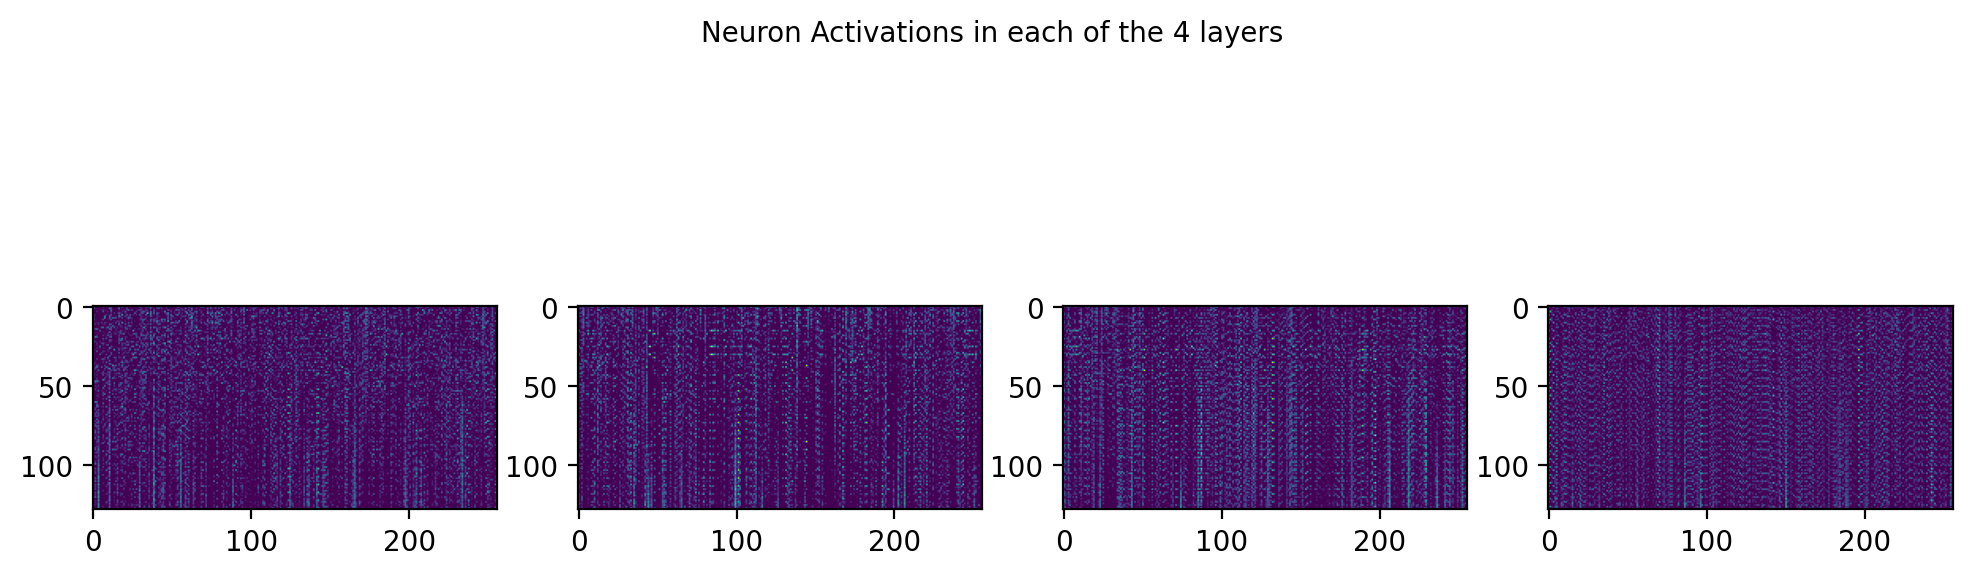

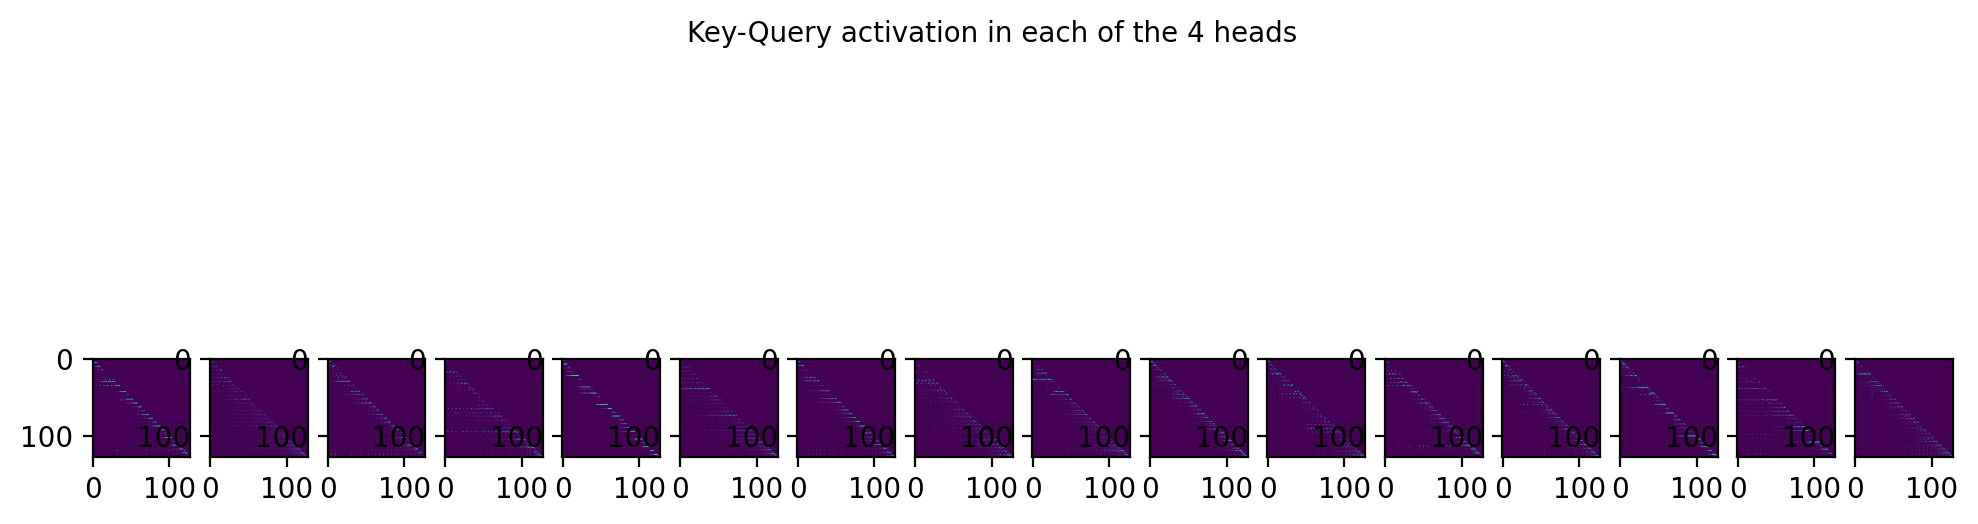

In [ ]:
# look at activations
# activations have been saved during model evaluation, and appended to the model_activations object
head_activations = model_activations['head'][-n_heads * n_layers:]
layer_activations = model_activations['layer'][-n_layers:]

sample_index = -1 # index of the context block we want to see the activation in response to
# print(model_activations['head'].shape)
# hist = model_activations['head'].view(-1).cpu()
# plt.hist(hist)

# maybe softmax activations together to see if there's an emergent pattern?
fig, axs = plt.subplots(1, len(layer_activations), figsize=(12, 4))
fig.suptitle(f"Neuron Activations in each of the {n_layers} layers", fontsize=10)
for i, act in enumerate(layer_activations):
  axs[i].imshow(act[sample_index].cpu())


fig, ax = plt.subplots(1, len(head_activations), figsize=(12, 4))
fig.suptitle(f"Key-Query activation in each of the {n_heads} heads", fontsize=10)
for i, act in enumerate(head_activations):
  ax[i].imshow(act[sample_index].cpu())

Junk Drawer

model generated with 452064 parameters
loss 0: 6.0496110916137695
(expected/theoretical loss at start: 5.863631175598097)
final loss: 2.2958664894104004
test-case loss: 2.271298408508301


NameError: ignored

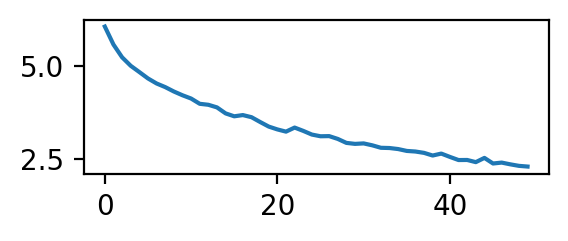

In [ ]:
# Run models for varying hyper-parameters

# run single instance of a model
# embedding_size = 32
# n_heads = 4
# model = run_model(iterations=5000, n_embed=embedding_size, n_heads=n_heads, plot_losses=True, loss_threshold = 0.2)
iterations = 50
model = Model(note_dimensions=embedding_size, n_heads=n_heads, loss_threshold=0.2)#.to('cuda')
losses = model.run_training(iterations)
test_size = min(100, Xtest.shape[0])
loss_test = model.evaluate_test(Xtest[:test_size], Ytest[:test_size])
print(f'Loss function evaluated against a sample size of {test_size}: {loss_test}')
if abs(loss_test - losses[-1]) > 0.5:
    print("model is probably overfitting !!")
# if not plot_losses:
  # return model

if len(losses) > 1000:
  plt.figure(figsize=(3, 1))
  chunks = torch.tensor(losses).chunk(100)
  plt.plot([chunk.mean() for chunk in chunks])
else:
  plt.figure(figsize=(3, 1))
  plt.plot(torch.tensor(losses))
plotResults(model, label=embedding_size)
# generated_sequence, generated_logits = generateMIDISequence(model, 128)
# pm = pretty_midi.PrettyMIDI('/content/midi-sequence.mid')
# display_audio(pm)

# for varying n_embed
# for n_embed in range(2, 9):
#   embedding_size = 2**n_embed
#   model = run_model(n_embed=embedding_size, plot_losses=False)
#   plotResults(model, label=embedding_size)

# for varying n_heads
# for n in range(0, 6):
#   embedding_size = 64
#   n_heads = 2**n # n_heads cannot exceed embedding_size
#   model = run_model(n_embed=embedding_size, n_heads=n_heads, plot_losses=False)
#   plotResults(model, label=embedding_size)

In [ ]:
# filename = 'large_11_28.pt'
filename = 'large_11_30.pt'
torch.save(model.state_dict(), filename)


In [ ]:
import gc
# del tokens
del Xtr
del Ytr
# len(tokens)
gc.collect()


1103

In [ ]:
# plt.imshow(model[2].weight.detach(), cmap='gray')
plt.figure(figsize=(20, 10))
plt.imshow(model[5].weight.detach(), cmap='gray')
model[3].weight.shape
# plt.imshow(model[3].weight.detach())
plt.hist(model[2].weight.detach())
# batchNorm_data = [p for p in model[3].parameters()]
# plt.hist(batchNorm_data[0].detach())

TypeError: ignored

<Figure size 2000x1000 with 0 Axes>

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

figsize = (6, 3)
title = 'Position Embeddings'

def plot_position_embeddings(model):
  def apply_pca(data, n_dims):
    pca = PCA(n_components=n_dims)
    y = pca.fit_transform(data)
    print(f"data {data}")
    print(f"y {y}")
    if dim == 1: return y[:, 0], np.zeros_like(y[:, 0])
    return y[:, 0], y[:, 1]


  emb = model.position_embeddings[-1].weight.detach()
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  for j, dim in enumerate([1, 2]):
    xs, ys = apply_pca(emb, dim)
    # plot
    ax[j].scatter(xs, ys, label=f'pca dim={dim}')
    for i in range(xs.shape[0]):
        ax[j].annotate(f'{i}', xy=(xs[i], ys[i]))
    fig.text(0.5, 0.95, title, ha='center', va='center', fontsize=16)

plot_position_embeddings(model)

AttributeError: ignored